# Investigating effect of input scaling on shape of weights

The objective here is to understand whether scaling the inputs will change the value of the weights. Concretely, if a network is trained on input data that is scaled to [0, 1], then we would like to know whether the network's weights are also scaled inversely if we scale the data further down by an order of magnitude or further up by an order of magnitude.

In [1]:
from keras.models import Sequential, Model, load_model
from keras import layers
import keras
from keras.datasets import mnist, cifar10
import sys
sys.path.append('C:/Users/320060820/experiments/')
import os
from quantize import FixedPointQuantizer
import quantize
from train_model import convert_data
import copy
import itertools

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
save_path = '../../test_models/'
model_path = 'cifar_keras/cifar_keras.h5'
num_classes = 10
batch_size = 32

### CIFAR Keras model

In [3]:
model1 = load_model(save_path + model_path)
model1_param = quantize.get_model_weights(model1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 2550.
x_test /= 2550.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

epochs = 70

In [5]:
x_train.max(), x_test.max()

(0.1, 0.1)

In [6]:
model2 = Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

# model.add(layers.Flatten())
model2.add(layers.GlobalMaxPooling2D())
model2.add(layers.Dropout(0.25))
model2.add(layers.Dense(num_classes, activation='softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001)

model2.compile(loss='categorical_crossentropy',
             optimizer = opt,
             metrics=['accuracy'])

In [8]:
history = model2.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    shuffle=True, 
                    validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/70
50000/50000 [==============================] - 22s 446us/step - loss: 3.3977 - acc: 0.1988 - val_loss: 1.8404 - val_acc: 0.3381
Epoch 2/70
50000/50000 [==============================] - 21s 410us/step - loss: 2.1670 - acc: 0.2669 - val_loss: 1.6746 - val_acc: 0.4110
Epoch 3/70
50000/50000 [==============================] - 21s 410us/step - loss: 1.9226 - acc: 0.3214 - val_loss: 1.5599 - val_acc: 0.4575
Epoch 4/70
50000/50000 [==============================] - 21s 411us/step - loss: 1.7686 - acc: 0.3678 - val_loss: 1.4771 - val_acc: 0.4881
Epoch 5/70
50000/50000 [==============================] - 20s 410us/step - loss: 1.6554 - acc: 0.4055 - val_loss: 1.4248 - val_acc: 0.5134
Epoch 6/70
50000/50000 [==============================] - 20s 410us/step - loss: 1.5743 - acc: 0.4320 - val_loss: 1.3717 - val_acc: 0.5260
Epoch 7/70
50000/50000 [==============================] - 21s 410us/step - loss: 1.4994 - acc: 0.4627 - val_loss: 1.

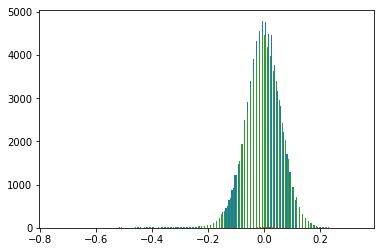

In [11]:
plt.hist(quantize.get_model_weights(model2), bins=100);
plt.hist(model1_param, bins=100);

### MNIST dataset

In [13]:
K.clear_session()
model3 = load_model(save_path + 'mnist_custom/mnist_keras.h5')
model3_param = quantize.get_model_weights(model3)

In [20]:
batch_size = 64
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 2550.
x_test /= 2550.

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
x_train.max(), x_test.max()

(0.1, 0.1)

In [22]:
model4 = Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model4.add(layers.BatchNormalization())
model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Dropout(0.25))

model4.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Dropout(0.25))

# pmo4del.add(layers.Flatten())
model4.add(layers.GlobalMaxPooling2D())
model4.add(layers.Dropout(0.25))
model4.add(layers.Dense(num_classes, activation='softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001)

model4.compile(loss='categorical_crossentropy',
             optimizer = opt,
             metrics=['accuracy'])

In [23]:
history = model4.fit(x_train, y_train,
                    epochs=20,
                    batch_size=batch_size,
                    shuffle=True, 
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 17s 276us/step - loss: 2.5237 - acc: 0.4670 - val_loss: 0.2471 - val_acc: 0.9385
Epoch 2/20
60000/60000 [==============================] - 16s 261us/step - loss: 0.8136 - acc: 0.7648 - val_loss: 0.1309 - val_acc: 0.9630
Epoch 3/20
60000/60000 [==============================] - 16s 260us/step - loss: 0.4819 - acc: 0.8599 - val_loss: 0.0926 - val_acc: 0.9760
Epoch 4/20
60000/60000 [==============================] - 16s 262us/step - loss: 0.3460 - acc: 0.9005 - val_loss: 0.0733 - val_acc: 0.9784
Epoch 5/20
60000/60000 [==============================] - 15s 256us/step - loss: 0.2627 - acc: 0.9232 - val_loss: 0.0709 - val_acc: 0.9796s: 0.2633 - acc:
Epoch 6/20
60000/60000 [==============================] - 15s 256us/step - loss: 0.2214 - acc: 0.9361 - val_loss: 0.0521 - val_acc: 0.9842
Epoch 7/20
60000/60000 [==============================] - 15s 256us/step - loss: 0.1849 - acc: 0.946

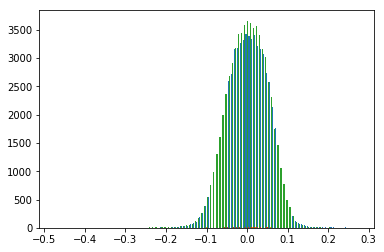

In [24]:
plt.hist(quantize.get_model_weights(model4), bins=100);
plt.hist(model3_param, bins=100);